In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math

%matplotlib inline

In [2]:
import keras 

from keras.layers import Lambda, Input, Dense, LSTM, SimpleRNN, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import l1, l2
from keras.utils import np_utils, plot_model

import pydot
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

# World Creation

In [44]:
class Best_World():

    # Enumeration of possible actions
    class Actions():
        left = 1
        right = 2
        forward = 3
        back = 4
        a = 5
        b = 6
        c = 7
        nothing = 8

    def __init__(
        self,
        grid_size=None,
        max_steps=50,
        obj_reward = 1,
    ):

        # Actions for this environment
        self.actions = {1:"left",2:"right",3:"forward",4:"back",5:"a",6:"b",7:"c",8:"nothing"}
        self.obj_reward = obj_reward
        # Environment configuration
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.grid = np.zeros((grid_size, grid_size, 6), dtype = np.uint8)
        self.end = False
        
        # Current positions of the agents
        self.agent1_pos = None
        self.agent2_pos = None
        
        self.action_costs = [0,0,0,0,0,0,0,0] #[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0]

    def place_object(self, obj_type=1):
        
        x = np.random.randint(0,self.grid_size)
        y = np.random.randint(0,self.grid_size)
        
        
        if obj_type == 1:
            r = 255
            g = 175
            b = 0
            f1 = 1
            f2 = 1
            f3 = 1
            
        if obj_type == 2:
            r = 255
            g = 175
            b = 50
            f1 = 1
            f2 = 0
            f3 = 0
        
        if obj_type == 3: 
            r = 255
            g = 175
            b = 100
            f1 = 1
            f2 = 1
            f3 = 0

        if obj_type == 4:   
            r = 255
            g = 175
            b = 150
            f1 = 1
            f2 = 0
            f3 = 1
            
        if obj_type == 5:      
            r = 255
            g = 1
            b = 50
            f1 = 0
            f2 = 1
            f3 = 1
        
        if obj_type == 6:         
            r = 255
            g = 1
            b = 100
            f1 = 0
            f2 = 1
            f3 = 1
    
        if obj_type == 7:      
            r = 255
            g = 1
            b = 150
            f1 = 0
            f2 = 0
            f3 = 1
            
        if obj_type == 8:        
            r = 255
            g = 1
            b = 200
            f1 = 0
            f2 = 1
            f3 = 0
            
    
        while True:
            if self.grid[x,y,0] == 0: # if nothing is there
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g
                self.grid[x,y,2] = b
                self.grid[x,y,3] = f1
                self.grid[x,y,4] = f2
                self.grid[x,y,5] = f3
                
                break
            else:
                x = np.random.randint(0,self.grid_size)
                y = np.random.randint(0,self.grid_size)
                
    def place_agent(self, num, on_obj=False, x=None, y=None):
        r = 1
        g = 255
        b = 0
        
        if x is None:
            x = np.random.randint(0,self.grid_size)
        else:
            if x > self.grid_size-1: #don't move out of the borders
                x = self.grid_size-1 
            elif x < 0:
                x = 0
                
        if y is None:
            y = np.random.randint(0,self.grid_size)
        else:
            if y > self.grid_size-1:
                y = self.grid_size-1 
            elif y < 0:
                y = 0
        
        if not on_obj: # if agent can't be placed on objects
            while True:
                if self.grid[x,y,0] == 0: # if nothing is there
                    if num == 1:
                        if self.agent1_pos is not None: # if agent already exists
                            prev_pos = self.agent1_pos # remove agent from previous position
                            self.grid[prev_pos[0],prev_pos[1],0] = 0
                            self.grid[prev_pos[0],prev_pos[1],1] = 0
                            self.grid[prev_pos[0],prev_pos[1],2] = 0
                        self.agent1_pos = (x,y) #set a new position
                        self.grid[x,y,0] = r
                        self.grid[x,y,1] = g-25 #one agent is lighter
                        self.grid[x,y,2]= b

                    elif num == 2:
                        if self.agent2_pos is not None:
                            prev_pos = self.agent2_pos # remove agent from previous position
                            self.grid[prev_pos[0],prev_pos[1],0] = 0
                            self.grid[prev_pos[0],prev_pos[1],1] = 0
                            self.grid[prev_pos[0],prev_pos[1],2] = 0
                        self.agent2_pos = (x,y) #set a new position
                        self.grid[x,y,0] = r
                        self.grid[x,y,1] = g
                        self.grid[x,y,2]= b
                    break

                else:
                    if num == 1:
                        if self.agent1_pos is None: # if agent doesn't exist
                            x = np.random.randint(0,self.grid_size)
                            y = np.random.randint(0,self.grid_size)
                        else: # or do not move
                            break
                    elif num == 2:
                        if self.agent2_pos is None: # if agent doesn't exist
                            x = np.random.randint(0,self.grid_size)
                            y = np.random.randint(0,self.grid_size)
                        else:
                            break
                    
        else: 
            if num == 1:
                if self.agent1_pos is not None: # if agent already exists
                    prev_pos = self.agent1_pos # remove agent from previous position
                    self.grid[prev_pos[0],prev_pos[1],0] = 0
                    self.grid[prev_pos[0],prev_pos[1],1] = 0
                    self.grid[prev_pos[0],prev_pos[1],2] = 0
                self.agent1_pos = (x,y) #set a new position
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g-55 #one agent is lighter
                self.grid[x,y,2]= b
                
            elif num == 2:
                if self.agent2_pos is not None:
                    prev_pos = self.agent2_pos # remove agent from previous position
                    self.grid[prev_pos[0],prev_pos[1],0] = 0
                    self.grid[prev_pos[0],prev_pos[1],1] = 0
                    self.grid[prev_pos[0],prev_pos[1],2] = 0
                self.agent2_pos = (x,y) #set a new position
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g
                self.grid[x,y,2]= b
                
    def step(self, ag1_action, ag2_action, step_i, reward1 = 0, reward2 = 0):
        
        ag1_input = np.resize(self.grid[:,:,3:6],(self.grid_size*self.grid_size*3,)) # make a single column
        ag1_input = np.concatenate((ag1_input, np.zeros((3)))) # add 3 "phonemes"
        ag2_input = ag1_input.copy()
        
        if ag1_action == 5:
            ag2_input[-3] = 1
        elif ag1_action == 6:
            ag2_input[-2] = 1
        elif ag1_action == 7:
            ag2_input[-1] = 1
            
        if ag2_action == 5:
            ag1_input[-3] = 1
        elif ag2_action == 6:
            ag1_input[-2] = 1
        elif ag2_action == 7:
            ag1_input[-1] = 1
        
        # agent 1 moving?
        x = self.agent1_pos[0]
        y = self.agent1_pos[1]
        if ag1_action == 1: # left
            x -= 1    
        elif ag1_action == 2: # right
            x += 1
        elif ag1_action == 3: # forward
            y += 1
        elif ag1_action == 4: # backward
            y -= 1
            
        self.place_agent(1, True, x, y)
        
        # agent 2 moving?
        x = self.agent2_pos[0]
        y = self.agent2_pos[1]
        if ag2_action == 1: # left
            x -= 1    
        elif ag2_action == 2: # right
            x += 1
        elif ag2_action == 3: # forward
            y += 1
        elif ag2_action == 4: # backward
            y -= 1
            
        self.place_agent(2, True, x, y)
        
        ag1_input = np.concatenate((ag1_input, np.array(self.agent1_pos))) # add agent position as input
        ag1_input = np.concatenate((ag1_input, np.array(self.agent2_pos))) # add the other agent position as input (for some simulations)
        
        ag2_input = np.concatenate((ag2_input, np.array(self.agent2_pos))) # add agent position as input
        ag2_input = np.concatenate((ag2_input, np.array(self.agent1_pos))) # other agent's position

        
        reward1 += self.action_costs[ag1_action-1]
        reward2 += self.action_costs[ag2_action-1]
        
        # rewards for bumping into objects
        if self.grid[self.agent1_pos[0],self.agent1_pos[1],3] == 1 or self.grid[self.agent1_pos[0],self.agent1_pos[1],4] == 1 or self.grid[self.agent1_pos[0],self.agent1_pos[1],5] == 1:
            reward1 += self.obj_reward
                
        if self.grid[self.agent2_pos[0],self.agent2_pos[1],3] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],4] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],5] == 1:
            reward2 += self.obj_reward
        
        if self.agent1_pos == self.agent2_pos and (self.grid[self.agent2_pos[0],self.agent2_pos[1],3] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],4] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],5] == 1):
            # winning game reward
            reward1 += 100
            reward2 += 100
            self.end = True # end the game
        
        #end game if reached maximum number of steps 
        elif step_i >= self.max_steps:
            self.end = True
            reward1 = 0
            reward2 = 0
        
        return(ag1_input, ag2_input, reward1, reward2, self.end)
    
    #visualization
    def show_world(self):
        img = Image.fromarray(self.grid[:,:,0:3], "RGB")
        img = img.resize((300,300))
        cv2.imshow("00", np.array(img))
        return(None)
        

In [45]:
def reset_env(size, num_obj):
    # world
    my_world = Best_World(size)
    # agents
    my_world.place_agent(1)
    my_world.place_agent(2)

    # random objects
    for i in range(num_obj):
        obj_type = np.random.randint(8)+1
        my_world.place_object(obj_type)
    
    return my_world

In [46]:
def vis_grid(env):
    img = Image.fromarray(env.grid[:,:,0:3], "RGB")
    img = img.resize((300,300))
    img = img.rotate(90)
    cv2.imshow('image',np.array(img))
    # saving the image
    cv2.imwrite('img.png',np.array(img))
    cv2.waitKey(1)    

### Birth of the agents!!!

In [52]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = collections.deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0])  # returns action from 0 to n-1
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if not done:
                target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state, batch_size=1)[0])
            target_f = self.model.predict(state, batch_size=1)
            target_f[0][action] = target
            self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [55]:
env_size = 8
num_obj = 8
episodes = 500
every = 100
print_every = 10

scores1 = []
scores2 = []
    
agent1 = DQNAgent(199, 8)
agent2 = DQNAgent(199, 8)

# Iterate the game
for e in range(episodes):
    # reset environment in the beginning of each game
    env = reset_env(env_size, num_obj)
    state1, state2, _, _, _ = env.step(8, 8, 0)
    score1 = 0
    score2 = 0
    incr = []
    for time_t in range(50):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        
        # agents act on the environment
        next_state1, next_state2, reward1, reward2, done = env.step(action1+1, action2+1, time_t)
        
        score1 += reward1
        score2 += reward2
        
        # store the experience
        agent1.remember(state1, action1, reward1, next_state1, done)
        agent2.remember(state2, action2, reward2, next_state2, done)
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        
        
        if e % every == 0:
            vis_grid(env)
        if done:
            break
        # train the agent with the experience of the episode
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    print("episode: {}/{}, score1: {}, score2: {}, steps: {}"
                  .format(e, episodes, score1, score2, time_t))
    
    # learn after each game
    agent1.replay(32)
    agent2.replay(32)
    
    scores1.append(score1)
    scores2.append(score2)

episode: 0/500, score1: 3, score2: 10, steps: 49
episode: 1/500, score1: 5, score2: 0, steps: 49
episode: 2/500, score1: 8, score2: 0, steps: 49
episode: 3/500, score1: 10, score2: 1, steps: 49
episode: 4/500, score1: 12, score2: 4, steps: 49
episode: 5/500, score1: 4, score2: 13, steps: 49
episode: 6/500, score1: 10, score2: 9, steps: 49
episode: 7/500, score1: 102, score2: 106, steps: 29
episode: 8/500, score1: 13, score2: 6, steps: 49
episode: 9/500, score1: 0, score2: 0, steps: 49
episode: 10/500, score1: 6, score2: 7, steps: 49
episode: 11/500, score1: 1, score2: 14, steps: 49
episode: 12/500, score1: 8, score2: 0, steps: 49
episode: 13/500, score1: 116, score2: 111, steps: 47
episode: 14/500, score1: 107, score2: 113, steps: 40
episode: 15/500, score1: 3, score2: 7, steps: 49
episode: 16/500, score1: 0, score2: 10, steps: 49
episode: 17/500, score1: 5, score2: 11, steps: 49
episode: 18/500, score1: 19, score2: 8, steps: 49
episode: 19/500, score1: 7, score2: 4, steps: 49
episode:

episode: 164/500, score1: 2, score2: 5, steps: 49
episode: 165/500, score1: 2, score2: 21, steps: 49
episode: 166/500, score1: 0, score2: 0, steps: 49
episode: 167/500, score1: 0, score2: 7, steps: 49
episode: 168/500, score1: 2, score2: 1, steps: 49
episode: 169/500, score1: 0, score2: 33, steps: 49
episode: 170/500, score1: 0, score2: 7, steps: 49
episode: 171/500, score1: 15, score2: 0, steps: 49
episode: 172/500, score1: 7, score2: 0, steps: 49
episode: 173/500, score1: 1, score2: 3, steps: 49
episode: 174/500, score1: 3, score2: 20, steps: 49
episode: 175/500, score1: 13, score2: 0, steps: 49
episode: 176/500, score1: 11, score2: 22, steps: 49
episode: 177/500, score1: 3, score2: 7, steps: 49
episode: 178/500, score1: 0, score2: 16, steps: 49
episode: 179/500, score1: 1, score2: 0, steps: 49
episode: 180/500, score1: 1, score2: 0, steps: 49
episode: 181/500, score1: 2, score2: 0, steps: 49
episode: 182/500, score1: 10, score2: 1, steps: 49
episode: 183/500, score1: 0, score2: 1, s

episode: 327/500, score1: 0, score2: 19, steps: 49
episode: 328/500, score1: 12, score2: 0, steps: 49
episode: 329/500, score1: 1, score2: 14, steps: 49
episode: 330/500, score1: 0, score2: 0, steps: 49
episode: 331/500, score1: 1, score2: 13, steps: 49
episode: 332/500, score1: 0, score2: 2, steps: 49
episode: 333/500, score1: 47, score2: 1, steps: 49
episode: 334/500, score1: 0, score2: 2, steps: 49
episode: 335/500, score1: 0, score2: 0, steps: 49
episode: 336/500, score1: 0, score2: 7, steps: 49
episode: 337/500, score1: 0, score2: 0, steps: 49
episode: 338/500, score1: 3, score2: 0, steps: 49
episode: 339/500, score1: 2, score2: 0, steps: 49
episode: 340/500, score1: 0, score2: 0, steps: 49
episode: 341/500, score1: 17, score2: 0, steps: 49
episode: 342/500, score1: 0, score2: 0, steps: 49
episode: 343/500, score1: 0, score2: 2, steps: 49
episode: 344/500, score1: 1, score2: 30, steps: 49
episode: 345/500, score1: 0, score2: 0, steps: 49
episode: 346/500, score1: 7, score2: 2, ste

episode: 490/500, score1: 23, score2: 0, steps: 49
episode: 491/500, score1: 0, score2: 0, steps: 49
episode: 492/500, score1: 0, score2: 0, steps: 49
episode: 493/500, score1: 22, score2: 0, steps: 49
episode: 494/500, score1: 0, score2: 1, steps: 49
episode: 495/500, score1: 0, score2: 1, steps: 49
episode: 496/500, score1: 1, score2: 1, steps: 49
episode: 497/500, score1: 0, score2: 0, steps: 49
episode: 498/500, score1: 0, score2: 0, steps: 49
episode: 499/500, score1: 0, score2: 2, steps: 49


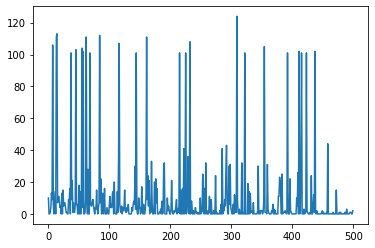

In [56]:
plt.plot(scores2)

### Recurrent agents

In [60]:
# Deep Q-learning Agent
class DQRNAgent:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=300)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(56, batch_input_shape=self.state_size, activation='relu'))
        model.add(Dense(16, batch_input_shape=self.state_size, activation='relu'))
        model.add(LSTM(16, return_sequences = True, stateful = True))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:])  # returns action
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        
        # weighted sampling with successful games gaining more weight
        #minibatch = [] 
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+30)/100: # sampling 'proportional' to the reward, failed game experiences are kept at the rate p
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            if len(experience)/2 >= self.episodes_len:
                experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences - more likely to learn from successes
            
            # for all the sequences in the sampled memory trace
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            
            # several (or one) seq samples from sampled experience
            for d in range(self.obs_from_ep): 
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    self.model.fit(states[k], target_f, batch_size=1, epochs=3, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [61]:
env_size = 8
num_obj = 8
episodes = 1000
every = 10
print_every = 10
replay_exp_length = 10

scores1 = []
scores2 = []
    
agent1 = DQRNAgent(199, 8, replay_exp_length)
agent2 = DQRNAgent(199, 8, replay_exp_length)

In [ ]:
# Iterate the game
episodes = 1000

for e in range(episodes):
    # reset state in the beginning of each game
    env = reset_env(env_size, num_obj)
    state1, state2, _, _, _ = env.step(8, 8, 0)
    score1 = 0
    score2 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    prev_done = False
    for time_t in range(70):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
            # Advance the game to the next frame based on the action.
            # Reward is 1 for every frame the pole survived
        next_state1, next_state2, reward1, reward2, done = env.step(action1, action2, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        
        score1 += reward1
        score2 += reward2
        
        #next_state = np.reshape(next_state, [1, 4])
        
        state1 = next_state1
        state2 = next_state2
        
        # break one step after the game ended
        if prev_done:
            break

        #if e % every == 0:
            #vis_grid(env)

        prev_done = done
    
    # remember the whole experience traces
    agent1.remember(experience1)
    agent2.remember(experience2)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    print("episode: {}/{}, score1: {}, score2: {}, steps: {}"
                  .format(e, episodes, score1, score2, time_t))
    if e > 32: #and e%100 == 0:
        agent1.replay(32)
        agent2.replay(32)
    
    scores1.append(score1)
    scores2.append(score2)

episode: 0/1000, score1: 2, score2: 2, steps: 51
episode: 1/1000, score1: 3, score2: 5, steps: 51
episode: 2/1000, score1: 6, score2: 8, steps: 51
episode: 3/1000, score1: 15, score2: 3, steps: 51
episode: 4/1000, score1: 108, score2: 103, steps: 25
episode: 5/1000, score1: 4, score2: 25, steps: 51
episode: 6/1000, score1: 13, score2: 11, steps: 51
episode: 7/1000, score1: 1, score2: 2, steps: 51
episode: 8/1000, score1: 0, score2: 8, steps: 51
episode: 9/1000, score1: 7, score2: 5, steps: 51
episode: 10/1000, score1: 0, score2: 7, steps: 51
episode: 11/1000, score1: 3, score2: 14, steps: 51
episode: 12/1000, score1: 6, score2: 7, steps: 51
episode: 13/1000, score1: 5, score2: 1, steps: 51
episode: 14/1000, score1: 1, score2: 0, steps: 51
episode: 15/1000, score1: 0, score2: 9, steps: 51
episode: 16/1000, score1: 2, score2: 1, steps: 51
episode: 17/1000, score1: 103, score2: 103, steps: 35
episode: 18/1000, score1: 5, score2: 15, steps: 51
episode: 19/1000, score1: 1, score2: 4, steps:

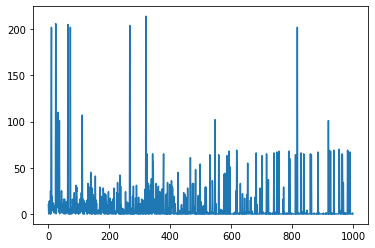

In [26]:
plt.plot(scores2)

## Simple Adversarial Game

In [20]:
class Second_Best_World():

    # Enumeration of possible actions
    class Actions():
        a = 1
        b = 2
        c = 3
        nothing = 4
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self,
        num_ent,
        max_steps=4):

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c",4:"nothing"}
        for i in range(num_ent):
            d[i+5] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.max_steps = max_steps
        self.end = False   
                
    def step(self, ag1_action, ag2_action, ag3_action, step_i, reward1 = 0, reward2 = 0, reward3 = 0):
        self.end = False
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        
        ag1_input = np.zeros((3,))
        ag2_input = np.zeros((3,))
        
        #ag1_input[1] = random.random()
        #ag2_input[1] = random.random()
        #ag1_input[2] = random.random()
        #ag2_input[2] = random.random()
        #ag1_input[3] = random.random()
        #ag2_input[3] = random.random()
        
        ag2_action = ag2_action+1
        ag1_action = ag1_action+1
        ag3_action = ag3_action+5
        
        # agent 1 talking
        if ag1_action == 1:
            ag2_input[0] = 1
            reward1 += 1
        elif ag1_action == 2:
            ag2_input[1] = 1
            reward1 += 1
        elif ag1_action == 3:
            ag2_input[2] = 1
            reward1 += 1
        
        #agent 2 talking
        if ag2_action == 1:
            ag1_input[0] = 1
            reward2 += 1
        elif ag2_action == 2:
            ag1_input[1] = 1
            reward2 += 1
        elif ag2_action == 3:
            ag1_input[2] = 1
            reward2 += 1
        
        # agent 1 choosing an entity?
        if ag1_action > 4 or ag2_action > 4:
            self.end = True # end the game
            if ag2_action == ag1_action: 
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = -1
                    reward2 = -1
                else:
                    reward3 = -1
                    reward1 = 1
                    reward2 = 1
            else:
                reward1 = -1
                reward2 = -1
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                            
        #end game if reached maximum number of steps 
        elif step_i >= self.max_steps:
            self.end = True
            reward1 = -1
            reward2 = -1
            reward3 = 0
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3, self.end)

In [21]:
# Deep Q-learning Agent
class DQRNAgent:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=1000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.2
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        #model.add(Dense(8, batch_input_shape=self.state_size, activation='relu'))
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        #model.add(Dense(8, activation='relu'))
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:])  # returns action
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #minibatch = [] # weighted sampling with successful games gaining more weight
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    self.model.fit(states[k], target_f, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [25]:
env_size = 8
replay_exp_length = 2
replay_exp_length3 = 2

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent(3, 7, replay_exp_length)
agent2 = DQRNAgent(3, 7, replay_exp_length)
agent3 = DQRNAgent(1, 4, replay_exp_length3)

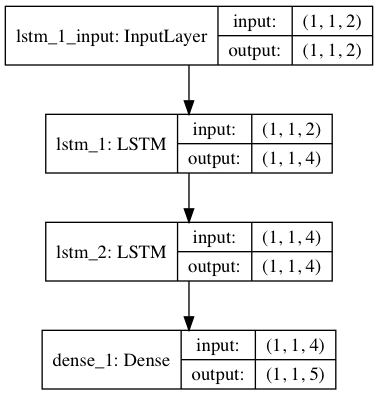

In [8]:
plot_model(agent1.model, show_shapes = True, to_file='model.png')

In [23]:
env = Second_Best_World(4)

In [26]:
# Iterate the game
episodes = 1000

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(4, 4, 1, 0)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(20):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        

        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    if len(agent1.memory) > 32 and len(agent2.memory) > 32: #and e%100 == 0:
        agent1.replay(32)
        agent2.replay(32)
    
    if len(agent3.memory) > 32:
        agent3.replay(32)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 1/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 2/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 3/1000, score1: 1, score2: 1, score3:-1, steps: 1
episode: 4/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 5/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 6/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 7/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 8/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 9/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 10/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 11/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 12/1000, score1: 2, score2: 2, score3:-1, steps: 2
episode: 13/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 14/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 15/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 16/1000, score1: -1, score2:

episode: 134/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 135/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 136/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 137/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 138/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 139/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 140/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 141/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 142/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 143/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 144/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 145/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 146/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 147/1000, score1: 3, score2: 3, score3:-1, steps: 3
episode: 148/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 149/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 150

episode: 268/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 269/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 270/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 271/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 272/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 273/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 274/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 275/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 276/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 277/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 278/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 279/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 280/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 281/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 282/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 283/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 284/

episode: 402/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 403/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 404/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 405/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 406/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 407/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 408/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 409/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 410/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 411/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 412/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 413/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 414/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 415/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 416/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 417/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 418

episode: 536/1000, score1: 2, score2: 2, score3:1, steps: 4
episode: 537/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 538/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 539/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 540/1000, score1: 1, score2: 1, score3:1, steps: 3
episode: 541/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 542/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 543/1000, score1: 2, score2: 2, score3:1, steps: 4
episode: 544/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 545/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 546/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 547/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 548/1000, score1: 1, score2: 1, score3:-1, steps: 1
episode: 549/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 550/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 551/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 552/1000, sc

episode: 670/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 671/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 672/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 673/1000, score1: 1, score2: 1, score3:1, steps: 3
episode: 674/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 675/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 676/1000, score1: 1, score2: 1, score3:1, steps: 3
episode: 677/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 678/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 679/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 680/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 681/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 682/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 683/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 684/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 685/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 686/1000, s

episode: 804/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 805/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 806/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 807/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 808/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 809/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 810/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 811/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 812/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 813/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 814/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 815/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 816/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 817/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 818/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 819/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 82

episode: 938/1000, score1: 0, score2: 0, score3:-1, steps: 2
episode: 939/1000, score1: 0, score2: 0, score3:1, steps: 2
episode: 940/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 941/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 942/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 943/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 944/1000, score1: 2, score2: 2, score3:-1, steps: 4
episode: 945/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 946/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 947/1000, score1: 3, score2: 3, score3:-1, steps: 5
episode: 948/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 949/1000, score1: 3, score2: 3, score3:0, steps: 5
episode: 950/1000, score1: -1, score2: -1, score3:1, steps: 1
episode: 951/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 952/1000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 953/1000, score1: 1, score2: 1, score3:-1, steps: 3
episode: 954/

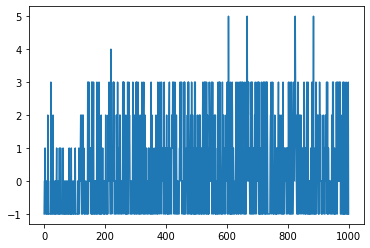

In [28]:
plt.plot(scores2)